In [1]:
# common imports 
import pandas as pd
import numpy as np

from tqdm import tqdm
import time
import os

# graphs
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split

# image
import PIL.Image as Image
import cv2 as cv

In [2]:
# pytorch imports
import torch
import torch.nn as nn

# torchvision
import torchvision 
import torchvision.transforms as transform

# torch dataloaders
import torch.functional as f
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split

# import functional

## DataLoader part

### creating binary mask from annotation

In [3]:
train_image_path = 'training_set/'
test_image_path = 'test_set_2/'

In [4]:
np.array( Image.open('training_set\\1_HC.png').convert('RGB') ).shape

(540, 800, 3)

In [5]:
image = np.array(Image.open('training_set\\1_HC_Annotation.png').convert('L'), dtype = np.float32)
pts = ( image == 255.0 )
pts = np.array( np.where(pts == True) , dtype = np.int32).T
pts[800:814]

array([[374, 314],
       [374, 315],
       [374, 504],
       [374, 505],
       [375, 314],
       [375, 315],
       [375, 504],
       [375, 505],
       [376, 314],
       [376, 315],
       [376, 504],
       [376, 505],
       [377, 314],
       [377, 315]])

In [6]:
pts[115:135]

array([[273, 449],
       [274, 391],
       [274, 392],
       [274, 393],
       [274, 394],
       [274, 395],
       [274, 396],
       [274, 397],
       [274, 398],
       [274, 399],
       [274, 444],
       [274, 445],
       [274, 446],
       [274, 447],
       [274, 448],
       [274, 449],
       [274, 450],
       [274, 451],
       [275, 389],
       [275, 390]])

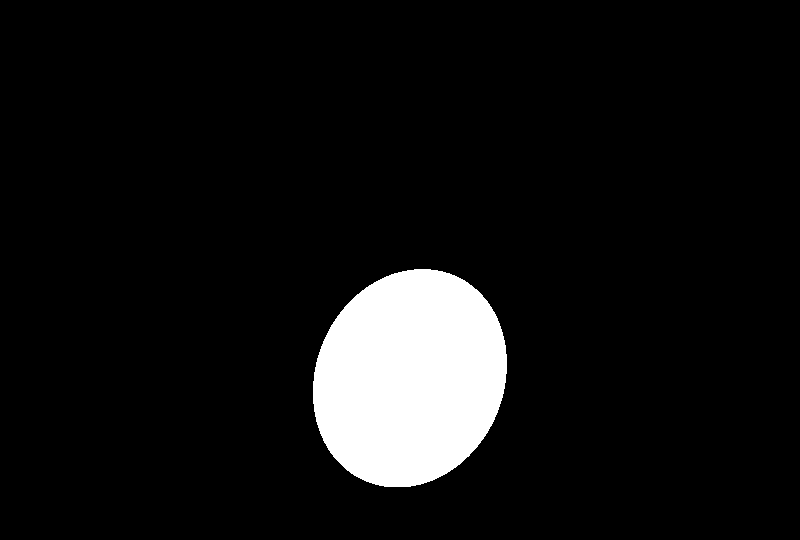

In [7]:
def make_mask(img):
    
    img = np.array(img)
    pts = np.array( np.where(img == 255.0) , dtype = np.int32).T
    n = len(pts)

    # print(img.max())

    row = pts[0][0]
    col1 = pts[0][1]
    col2 = pts[0][1]

    for j,i in enumerate(pts):

        if row != i[0] or j == n-1:
            img[row,col1:col2] = 255.0
            row = i[0]
            col1 = i[1]
            col2 = i[1]
            continue
        
        col2 = i[1]

    return img

Image.fromarray( make_mask(image) ).convert('L')

### Dataloader

In [8]:
class train_image_loader(Dataset):

    def __init__(self, path = train_image_path, transformations = transform.transforms.ToTensor() ):

        self.root = path
        self.image_list = os.listdir(path)
        self.transformations = transformations
    
    def __len__(self):
        return int( len(self.image_list)//2 )
    
    def __getitem__(self,index):

        img_path =  self.image_list[ 2*index  +  1]
        mask_path = self.image_list[ 2*index ]

        # getting the paths 
        total_mask_path, total_img_path = os.path.join( self.root, img_path ), os.path.join( self.root, mask_path )

        # getting the image and mask
        image = Image.open( total_img_path )
        # print(total_img_path, total_mask_path)
        mask = Image.fromarray( make_mask( Image.open( total_mask_path ).convert('L') )  )

        # doing transformations if any of them is there
        if self.transformations:
            image = self.transformations(image)
            mask = self.transformations(mask)

        # print(f' image shape : {image.shape} and mask shape : {mask.shape} ')
        
        return image, mask


In [9]:
class test_image_loader():
     
    def __init__(self, path = test_image_path, transformations = transform.transforms.ToTensor() ):

        self.root = path
        self.image_list = os.listdir(path)
        self.transformations = transformations
    
    def __len__(self):
        return int( len(self.image_list) )
    
    def __getitem__(self,index):

        img_path =  self.image_list[ index ]

        # getting the paths 
        total_img_path = os.path.join( self.root, img_path )

        # getting the image 
        image = Image.open( total_img_path ).convert('L')

        # doing transformations if any of them is there
        if self.transformations:
            image = self.transformations(image)
        
        return image

In [10]:
batch_size = 4
transformations = transform.Compose([

    transform.transforms.ToTensor(), 
    transform.transforms.Resize(size = [540,800]),

])

In [11]:
train_dataset = train_image_loader(transformations = transformations,)

# creating cal and train split
val,train = random_split(dataset = train_dataset, lengths = [799,200] )

# creating val and train dataloader
train_dataloader = DataLoader(train, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val, batch_size = batch_size, shuffle = True)

#creating test dataloader
test_dataset = test_image_loader(transformations = transformations,)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

torch.Size([1, 540, 800])
(540, 800)
(540, 800, 3)


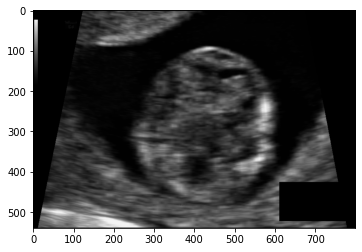

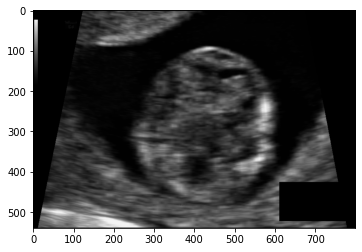

In [12]:
# testing

for i in test_dataloader:

    print(i[0].shape)
    img = i[2].squeeze().detach().cpu().numpy()*255 
    print(img.shape)
    k1 = Image.fromarray(img,).convert('RGB')
    print( np.array(k1).shape )
    k2 = Image.fromarray( i[2].squeeze().detach().cpu().numpy()*255 )
    # print(i[0].shape)

    break


plt.imshow(k1)
plt.show()
plt.imshow(k2)

## Model

In [13]:
# Model for convolution Down-sampling

class Down_Sampler(nn.Module):

    def __init__(self, input_channel, output_channel):

        # It will take an input and increase no og channels and perform conv operation

        super(Down_Sampler, self).__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel

        self.conv_layer = nn.Sequential(

            nn.Conv2d(input_channel, output_channel, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.BatchNorm2d(output_channel),
            # nn.ReLU(),

            nn.Conv2d(output_channel, output_channel, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),

            # nn.Conv2d(output_channel, output_channel, kernel_size = 3, stride = 1, padding = 1),
            # nn.ReLU(),
        )

    def forward(self, image):

        x = self.conv_layer(image)
        return x

# class up-sampler

class Up_Sampler(nn.Module):
    
    def __init__(self, input_channel, hidden_channel, output_channel ):

        # It will take an input and increase no og channels and perform conv operation

        super(Up_Sampler, self).__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.hidden_channel = hidden_channel

        # this to convert given input to up-scale
        self.de_conv_layer = nn.ConvTranspose2d( self.input_channel, self.output_channel, stride = 2, kernel_size = 2, )

        # this to perform conv operation on up-scaled input
        self.conv_layer = nn.Sequential(

            nn.Conv2d( self.hidden_channel, self.output_channel, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.BatchNorm2d(self.output_channel),
            nn.ReLU(),

            nn.Conv2d( self.output_channel, self.output_channel, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.BatchNorm2d(self.output_channel),
            nn.ReLU(),

        )
    
    def forward(self, low_resolution_input, high_resolution_input):

        x = self.de_conv_layer(low_resolution_input)

        if high_resolution_input is not None:
            
            # resizing if the inputs are not matching
            if x.shape[-2:] != high_resolution_input.shape[-2:] : 
                x = transform.functional.resize( x, size = high_resolution_input.shape[-2:] )

            # concatenating the inputs
            # print(x.shape, high_resolution_input.shape)
            y = torch.concat([x,high_resolution_input], dim = 1)

        else:
            y = x

        # print(f" test - 1 the shape of the joined images : {y.shape}")
        # raise Exception(' test - 1 in up-sample ') # -> Test Passed

        # the up-sampled image with conv operation:
        up_sampled_image = self.conv_layer(y)

        return up_sampled_image

In [14]:
# building encoder - decoder model

class encoder_decoder_model(nn.Module):

    def __init__(self, input_channels = 1, arch = [64,128], output_channels = 1):

        super(encoder_decoder_model, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.arch = arch

        # down_sample and up_sample layers
        self.down_sample = nn.ModuleList()
        self.up_sample = nn.ModuleList()

        # max-pool layer
        self.pooler = nn.MaxPool2d(stride = 2, kernel_size = 2)

        input_channel = self.input_channels

        # creating the down-sample layers
        for i,v in enumerate(arch):
            
            self.down_sample.append(
                Down_Sampler(input_channel, v),
            )

            input_channel = v
        
        # creating the up-sample layers
        input_channel = arch[-1]
        for i,v in enumerate(reversed(arch[:-1])):

            self.up_sample.append(
                Up_Sampler(input_channel, 2*v , v)
            )

            input_channel = v
        
        self.final_output_layer = nn.Sequential(

            nn.Conv2d( arch[0], arch[0], kernel_size = 3, stride = 1, padding = 1 ),
            # nn.ReLU(),

            nn.Conv2d( arch[0], arch[0], kernel_size = 3, stride = 1, padding = 1 ),
            nn.ReLU(),

            nn.Conv2d( arch[0], self.output_channels, kernel_size = 3, stride = 1, padding = 1 ),
            
        )
    
    def forward(self, input, ):

        # to save output from each layer
        skip_connections = []
        x = input

        for i,down in enumerate(self.down_sample):

            x = down(x)

            # raise Exception(f" checking outputs in the down-sampling layer {x.shape} ") # -> test passed

            if i != ( len(self.down_sample) - 1) : 

                # appending the the outputs, storing the outputs if it is not the final layer
                skip_connections.append(x)

                # pooling if it is not the final layer
                x = self.pooler(x)
            
            # raise Exception(f" checking outputs in the down-sampling layer {x.shape} ") # -> Test Passed
            # print(x.shape)
        
        # for making the input process simpler, we are reversing the list
        skip_connections = skip_connections[::-1]
        
        for i,ups in enumerate(self.up_sample):

            # raise Exception(f" checking inputs in the up-sampling layer {x.shape} and {skip_connections[i].shape}") # -> Test Passed
            x = ups( x, skip_connections[i] )
            # print(x.shape)

            # raise Exception(f" checking outputs in the up-sampling layer {x.shape} and {skip_connections[i].shape}") # -> Test Passed
        
        final_output = self.final_output_layer(x)
        # raise Exception(f" checking outputs in the up-sampling layer {final_output.shape} ") # -> Test Passed
    
        return final_output

In [15]:
encoder_decoder = encoder_decoder_model()

# for i in train_dataloader:
#     out = encoder_decoder( i[0] )
#     break

## Model Trainer

In [16]:
def Dice_Score(pred, truth):

    # Both should be a tensor 
    # pred should be from 0 to 1

    prediction = torch.where(pred > 0.5, 1.0, 0.0)
    # print(prediction)
    IOU = prediction*truth
    score = 200*( IOU.sum() )/( prediction.sum() + truth.sum() )

    return score.item()

# example
dummy_pred = torch.rand(4,1,540,800)
dummy_truth = torch.randint(low=0, high=2 ,size = (4,1,540,800) )
Dice_Score(dummy_pred, dummy_truth)

50.043941497802734

In [17]:
# hyper parameters:

lr = 1e-3
epochs = 6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_image_path = 'training_set/'
test_image_path = 'test_set_2/'

batch_size = 2
transformations = transform.Compose([

    transform.transforms.ToTensor(), 
    transform.transforms.Resize(size = [540,800]),

])

optimizer = torch.optim.Adam
optimizer_params = {'lr' : lr}

In [18]:
train_dataset = train_image_loader(transformations = transformations,)

# creating cal and train split
train,val = random_split(dataset = train_dataset, lengths = [799,200] )

# creating val and train dataloader
train_dataloader = DataLoader(train, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val, batch_size = batch_size, shuffle = True)

#creating test dataloader
test_dataset = test_image_loader(transformations = transformations,)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

print(f" There are total '{len(train_dataloader)}' batches in train data ")

 There are total '400' batches in train data 


In [19]:
class Segmentation_Trainer():

    def __init__(self, name, model, optimizer = optimizer , optimizer_params = optimizer_params, train_dataloader = train_dataloader, test_dataloader = test_dataloader, val_dataloader = val_dataloader,):

        # initializing models
        self.name = name
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.val_dataloader = val_dataloader
        self.optimizer_params = optimizer_params

        # optimizers and loss fn
        self.optimizer = optimizer(self.model.parameters(), **self.optimizer_params)
        self.loss = nn.BCEWithLogitsLoss()
    
    def eval(self, evaluation_fn = Dice_Score):

        epoch_loss = 0
        epoch_metric = 0

        with torch.cuda.amp.autocast() and torch.no_grad() :

            for index,batch in tqdm( enumerate(self.val_dataloader), total = len(val_dataloader), desc = 'val epoch progress' ):

                    image,mask = batch

                    # changing type and data type of the image to ensure computability
                    image = image.to(device).type(torch.float32)
                    mask = mask.to(device).type(torch.float32)

                    # getting the prediction from the model
                    pred = self.model(image)

                    # computing loss
                    Loss = self.loss(pred, mask)

                    # calculating loss
                    epoch_loss += Loss.item()*len(image)
                    epoch_metric += evaluation_fn( torch.sigmoid(pred) , mask )*len(image)
        
        return epoch_loss/200, epoch_metric/200

    def train_model(self, epochs = 10, print_freq = 1, save_freq = 1, evaluation_fn = Dice_Score):

        train_loss = []
        train_metric = []

        val_loss = []
        val_metric = []

        # with torch.cuda.amp.autocast():

        if epochs > 0:

            for e in range(epochs):

                epoch_loss = 0
                epoch_metric = 0

                loop_obj = tqdm( enumerate(self.train_dataloader), total = len(train_dataloader), desc = 'train epoch progress' )

                for index,batch in loop_obj:

                    image,mask = batch

                    # zero_grad optimizer to erase previous gradients
                    self.optimizer.zero_grad()

                    # changing type and data type of the image to ensure computability
                    image = image.to(device).type(torch.float32)
                    mask = mask.to(device).type(torch.float32)

                    # getting the prediction from the model
                    pred = self.model(image)

                    # computing loss
                    Loss = self.loss(pred, mask)

                    # raise Exception(f" Checking the size of the loss : {Loss} ")
                    loop_obj.set_description(f" Loss is : {Loss} ", refresh = True)

                    # updating weights
                    Loss.backward()
                    self.optimizer.step()

                    # calculating loss
                    epoch_loss += Loss.item()*len(image)
                    epoch_metric += evaluation_fn( torch.sigmoid(pred), mask )*len(image)
                
                # Now storing the Loss and metric of every epoch
                train_loss.append( epoch_loss/799 )
                train_metric.append( epoch_metric/799 )

                # Now storing the value of val loss and val metric
                validation_data = self.eval()

                # Now storing them in the validation history
                val_loss.append(validation_data[0])
                val_metric.append(validation_data[1])

                if (e+1) % print_freq == 0  :

                    print(f"\n=====================================================")
                    print(f" The current epoch is : {e+1}")
                    print(f" Train Loss is : {train_loss[-1]:.3f}")
                    print(f" Train Dice Score is : {train_metric[-1]:.3f}")
                    print(f" Validation Loss is : {validation_data[0]:.3f}")
                    print(f" Validation Dice Score is : {validation_data[1]:.3f}")
                    print(f"=====================================================\n")
                
                if (e+1) % save_freq == 0  :
                    torch.save(self.model.state_dict(), f'saved_model/{self.name}/{e}.pt')
             
        return [train_loss, train_metric, val_loss, val_metric]
    
    
    def plot_data(self, train_loss, train_metric, val_loss, val_metric,):
        
        plt.figure(figsize = (20,12) )

        plt.subplot(2,2,1)

        plt.plot(train_loss, label = f'train_loss')
        plt.title(f'train loss ')
        plt.xlabel('epochs')
        plt.ylabel('train_loss')
        plt.legend(loc = 'best')

        plt.subplot(2,2,2)

        plt.plot(val_loss, label = f'val_loss')
        plt.title(f'val loss ')
        plt.xlabel('epochs')
        plt.ylabel('val_loss')
        plt.legend(loc = 'best')

        plt.subplot(2,2,3)

        plt.plot(train_metric, label = f'train_metric')
        plt.title(f'train metric')
        plt.xlabel('epochs')
        plt.ylabel('train_metric')
        plt.legend(loc = 'best')

        plt.subplot(2,2,4)

        plt.plot(val_metric, label = f'val_metric')
        plt.title(f'val metric')
        plt.xlabel('epochs')
        plt.ylabel('val_metric')
        plt.legend(loc = 'best')

        plt.show()


## training encoder - decoder 

In [22]:
basic_encoder_decoder = encoder_decoder_model( arch = [ 16, 32, 64, ] ).to(device)
basic_encoder_decoder.load_state_dict( torch.load('saved_model\\basic_encoder_decoder_540_800\9.pt', map_location = device) )
print(f" total params in the model is : {sum([p.numel() for p in basic_encoder_decoder.parameters() if p.requires_grad ])*1e-6:.3f} M")

 total params in the model is : 0.122 M


In [23]:
Basic_encoder_trainer = Segmentation_Trainer( 'basic_encoder_decoder_540_800', basic_encoder_decoder )

In [197]:
data = Basic_encoder_trainer.train_model(epochs = 10)
Basic_encoder_trainer.eval()

val epoch progress: 100%|██████████| 50/50 [00:10<00:00,  4.58it/s]



 The current epoch is : 1
 Train Loss is : 0.481
 Train Dice Score is : 34.150
 Validation Loss is : 0.450
 Validation Dice Score is : 49.248



val epoch progress: 100%|██████████| 50/50 [00:10<00:00,  4.57it/s]



 The current epoch is : 2
 Train Loss is : 0.434
 Train Dice Score is : 56.990
 Validation Loss is : 0.428
 Validation Dice Score is : 62.042



val epoch progress: 100%|██████████| 50/50 [00:11<00:00,  4.47it/s]



 The current epoch is : 3
 Train Loss is : 0.410
 Train Dice Score is : 61.444
 Validation Loss is : 0.408
 Validation Dice Score is : 65.419



val epoch progress: 100%|██████████| 50/50 [00:10<00:00,  4.60it/s]



 The current epoch is : 4
 Train Loss is : 0.381
 Train Dice Score is : 67.505
 Validation Loss is : 0.366
 Validation Dice Score is : 70.122



val epoch progress: 100%|██████████| 50/50 [00:10<00:00,  4.58it/s]



 The current epoch is : 5
 Train Loss is : 0.369
 Train Dice Score is : 69.338
 Validation Loss is : 0.358
 Validation Dice Score is : 73.347



val epoch progress: 100%|██████████| 50/50 [00:11<00:00,  4.51it/s]



 The current epoch is : 6
 Train Loss is : 0.348
 Train Dice Score is : 72.052
 Validation Loss is : 0.350
 Validation Dice Score is : 71.661



val epoch progress: 100%|██████████| 50/50 [00:11<00:00,  4.53it/s]



 The current epoch is : 7
 Train Loss is : 0.337
 Train Dice Score is : 73.308
 Validation Loss is : 0.341
 Validation Dice Score is : 73.031



val epoch progress: 100%|██████████| 50/50 [00:11<00:00,  4.48it/s]



 The current epoch is : 8
 Train Loss is : 0.331
 Train Dice Score is : 73.849
 Validation Loss is : 0.336
 Validation Dice Score is : 75.763



val epoch progress: 100%|██████████| 50/50 [00:11<00:00,  4.45it/s]



 The current epoch is : 9
 Train Loss is : 0.327
 Train Dice Score is : 74.305
 Validation Loss is : 0.316
 Validation Dice Score is : 75.591



val epoch progress: 100%|██████████| 50/50 [00:11<00:00,  4.47it/s]



 The current epoch is : 10
 Train Loss is : 0.317
 Train Dice Score is : 75.148
 Validation Loss is : 0.325
 Validation Dice Score is : 76.049



val epoch progress: 100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


(0.32701886773109434, 76.10311309814453)

In [210]:
len(data)

4

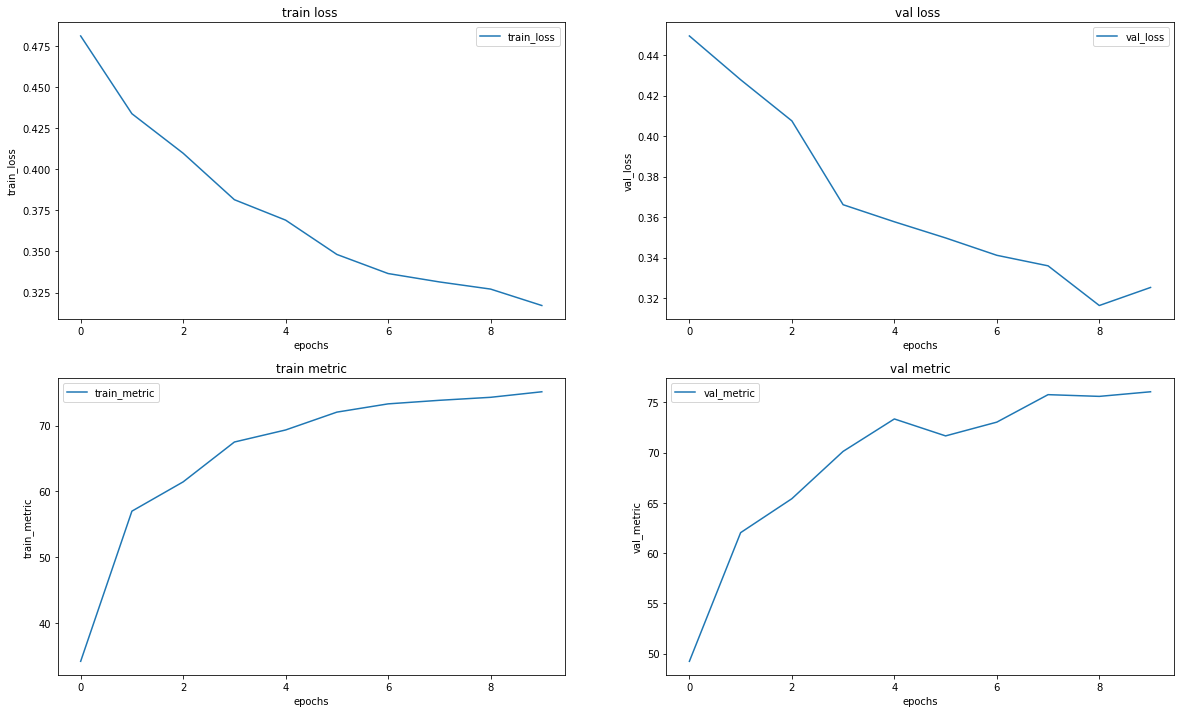

In [211]:
Basic_encoder_trainer.plot_data( data[0], data[1], data[2], data[3] )

In [287]:
# saving the data
# basic_encoder_df = pd.DataFrame({'train_loss' : data[0], 'train_metric' : data[1], 'validation_loss' : data[2], 'validation_metric' : data[3]})
# basic_encoder_df.to_csv('basic_encoder_decoder_data.csv')

### Unet model

In [20]:
Unet = encoder_decoder_model( arch = [ 32, 64, 128, 256, ] ).to(device)
# Unet.load_state_dict( torch.load('saved_model\\basic_encoder_decoder_540_800\9.pt', map_location = device) )
print(f" total params in the model is : {sum([p.numel() for p in Unet.parameters() if p.requires_grad ])*1e-6:.3f} M")

 total params in the model is : 1.945 M


In [21]:
Unet_trainer = Segmentation_Trainer( 'UNET', Unet )

In [22]:
Unet_data = Unet_trainer.train_model(epochs = 10)
Unet_trainer.eval()

val epoch progress: 100%|██████████| 100/100 [00:26<00:00,  3.72it/s]



 The current epoch is : 1
 Train Loss is : 0.409
 Train Dice Score is : 58.018
 Validation Loss is : 0.327
 Validation Dice Score is : 75.476



val epoch progress: 100%|██████████| 100/100 [00:35<00:00,  2.85it/s]



 The current epoch is : 2
 Train Loss is : 0.303
 Train Dice Score is : 77.050
 Validation Loss is : 0.289
 Validation Dice Score is : 79.038



val epoch progress: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s]



 The current epoch is : 3
 Train Loss is : 0.271
 Train Dice Score is : 80.040
 Validation Loss is : 0.285
 Validation Dice Score is : 79.282



val epoch progress: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s]



 The current epoch is : 4
 Train Loss is : 0.251
 Train Dice Score is : 81.607
 Validation Loss is : 0.233
 Validation Dice Score is : 83.320



val epoch progress: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]



 The current epoch is : 5
 Train Loss is : 0.235
 Train Dice Score is : 83.046
 Validation Loss is : 0.217
 Validation Dice Score is : 84.135



val epoch progress: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]



 The current epoch is : 6
 Train Loss is : 0.212
 Train Dice Score is : 84.507
 Validation Loss is : 0.211
 Validation Dice Score is : 84.964



val epoch progress: 100%|██████████| 100/100 [00:23<00:00,  4.17it/s]



 The current epoch is : 7
 Train Loss is : 0.203
 Train Dice Score is : 85.074
 Validation Loss is : 0.217
 Validation Dice Score is : 81.811



val epoch progress: 100%|██████████| 100/100 [00:24<00:00,  4.13it/s]



 The current epoch is : 8
 Train Loss is : 0.189
 Train Dice Score is : 86.147
 Validation Loss is : 0.171
 Validation Dice Score is : 87.726



val epoch progress: 100%|██████████| 100/100 [00:24<00:00,  4.13it/s]



 The current epoch is : 9
 Train Loss is : 0.176
 Train Dice Score is : 86.971
 Validation Loss is : 0.171
 Validation Dice Score is : 87.570



val epoch progress: 100%|██████████| 100/100 [00:24<00:00,  4.12it/s]



 The current epoch is : 10
 Train Loss is : 0.166
 Train Dice Score is : 87.907
 Validation Loss is : 0.163
 Validation Dice Score is : 88.274



val epoch progress: 100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


(0.1668174184113741, 87.70567291259766)

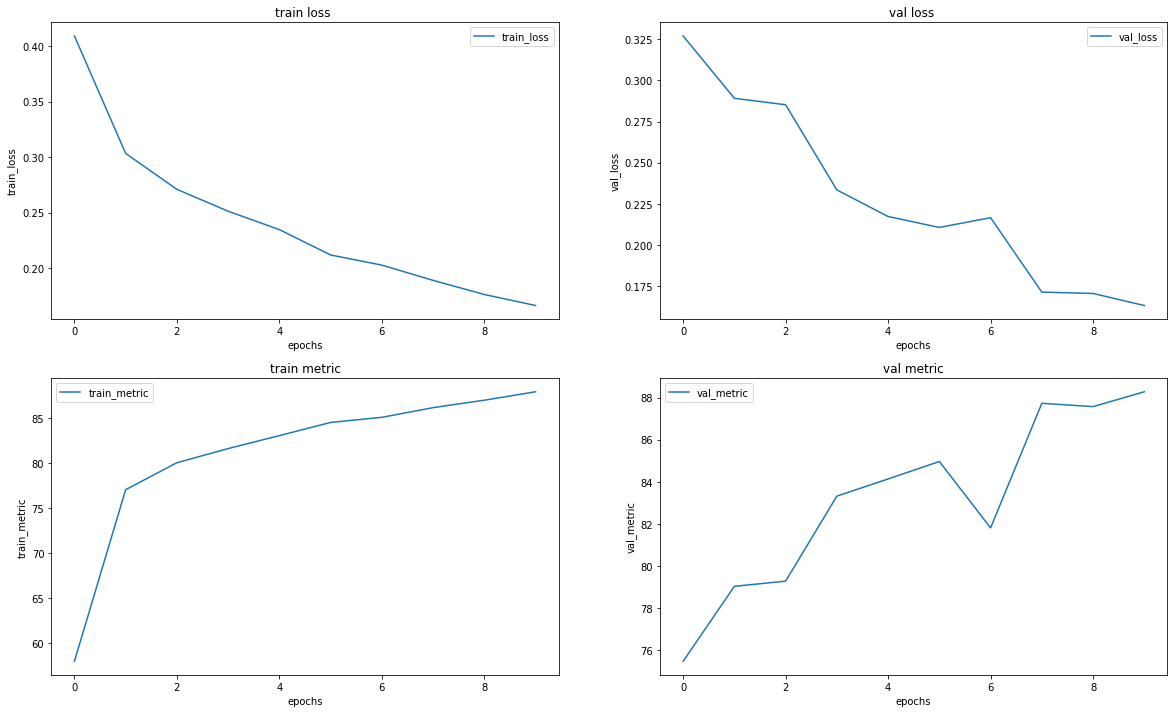

In [23]:
Unet_trainer.plot_data(*Unet_data)

***`We can see that the Unet model architecture is able to 88% dice score in validation and train set , but basic model is only able to do around 75 %`***

## testing models

In [24]:
class test_model(): 

    def __init__(self, model, root, test_images, test_dataloader = test_dataloader, ) :

        self.model = model.eval()

        self.test_images = test_images
        self.root = root
        
        self.test_dataloader = test_dataloader
    
    def test_model(self, save_path = None):

        # to store numpy array of predicted masks
        masks = []
        images = []

        with torch.no_grad():

            loop_obj = tqdm( enumerate(self.test_dataloader), desc = 'test images' , total = len(self.test_dataloader) )

            for index,batch in loop_obj :

                image = batch

                # changing type and data type of the image to ensure computability
                image = image.to(device).type(torch.float32)

                predicted_mask = torch.sigmoid( self.model(image) )

                masks.append( torch.where(predicted_mask > 0.5, 1.0, 0).detach().cpu().numpy().squeeze(1) )
                images.append( image.detach().cpu().numpy().squeeze(1) )

                # print(masks[0].shape)
                # break
        
        self.test_masks = np.concatenate(masks)
        images = np.concatenate(images)

        return self.test_masks,images
    
    def show_example(self, masks, n = 1, images = None):

        indexes = np.random.randint(low = 0 , high = len(masks) , size = [n] )

        for i,v in enumerate(indexes):

            plt.figure(figsize = (20,10))
            # print( masks[i].shape, np.array(Image.open(os.path.join(self.root,self.test_images[v]))).shape )

            if images is not None : image = images[v]
            else:  image = Image.open(os.path.join(self.root,self.test_images[v]) ).convert('RGB')

            mask = Image.fromarray(masks[v]*255).convert('RGB')

            plt.subplot(n,2,i+1)
            plt.imshow( image )

            plt.subplot(n,2,2+i)
            plt.imshow( mask )


In [25]:
Tester = test_model(model = Unet, root = 'test_set\\', test_images = os.listdir('test_set'), )

In [26]:
test_masks,images = Tester.test_model()

test images: 100%|██████████| 168/168 [00:36<00:00,  4.65it/s]


In [27]:
test_masks[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

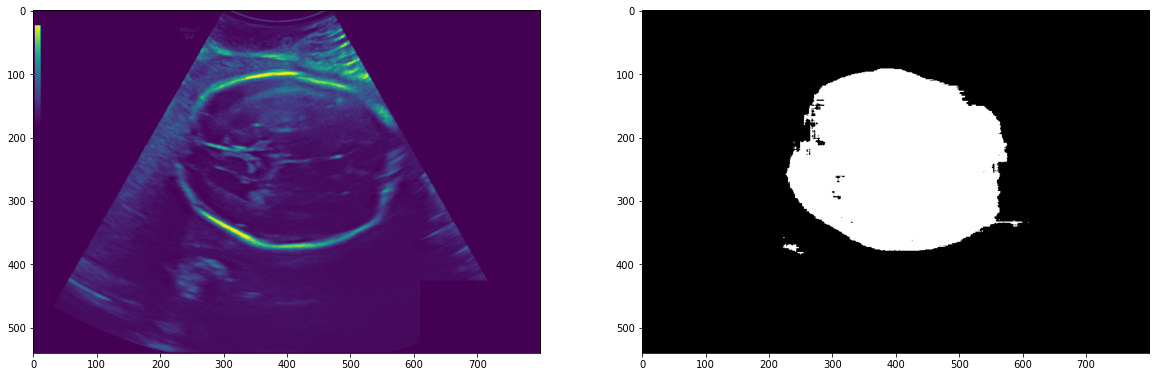

In [37]:
Tester.show_example(masks = test_masks, images = images)